In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from matplotlib.colors import LogNorm

from SimPEG import Mesh, Maps
from SimPEG.EM import FDEM

from pymatsolver import Pardiso

# import empymod for comparison
from empymod import bipole

# interaction
import ipywidgets as widgets

%matplotlib inline

In [2]:
rcParams["font.size"] = 12

### define layered model

In [3]:
rho_h_layers = np.r_[1e8, 100, 5, 100]
rho_v_layers = np.r_[1e8, 100, 20, 100]

layer_tops = np.r_[0, -100, -500]  # z-positive up in SimPEG

### survey parameters

In [4]:
src_a = np.r_[0., 0., 0.]
src_b = np.r_[0., 400., 0.]
coil_separations = np.linspace(0,1000,200)
rx_offsets = np.vstack([np.r_[sep, 0., 0.] for sep in coil_separations])
rx_loc = rx_offsets

#rx_times = np.logspace(np.log10(5e-4), 0, 200)
freq = 3e1

### set up a mesh

In [28]:

# check the diffusion distance 
#skin depth
def diffusion_distance(rho, f):
    #return 1260*np.sqrt(t*rho)
    return 503/np.sqrt(f*(1/rho))

print(f"Skin depth is {diffusion_distance(rho_v_layers[1], freq):1.0e}m")
#print(f"Starting skin depth is {diffusion_distance(rho_v_layers[0], freq[0]):1.0e}m")
#print(f"Ending skin depth is {diffusion_distance(rho_v_layers[-1], freq[-1]):1.0e}m")

Skin depth is 9e+02m


In [6]:

# cell widths in the core region of the mesh
hx = 100
hy = 100
hz = 50

# extent of the core region of the mesh (uniform cell sizes)
n_core_x = int(np.ceil(coil_separations[-1]/hx)) + 2
n_core_y = n_core_x
n_core_z = int(np.ceil(-layer_tops[-1]/hz))

# number of padding cells in each dimension
npadx = 11
npady = 11
npadz = 12

# padding factor
pad_factor = 1.5




In [7]:
npadz+n_core_z

22

In [8]:
#(
#       (cellSize, numPad, [, increaseFactor]),(cellSize, numCore),
#       (cellSize, numPad, [, increaseFactor]))

mesh = Mesh.TensorMesh([
    [(hx, npadx, -pad_factor), (hx, n_core_x), (hx, npadx, pad_factor)],
    [(hy, npady, -pad_factor), (hy, n_core_y), (hy, npady, pad_factor)],
    [(hz, npadz, -pad_factor), (hz, n_core_z), (hz, npadz, pad_factor)],
])

mesh.x0 = np.r_[
    -mesh.hx[:npadx+1].sum(), 
    -mesh.hy[:npady+1].sum(), 
    -mesh.hz[:(npadz+n_core_z)].sum()
]

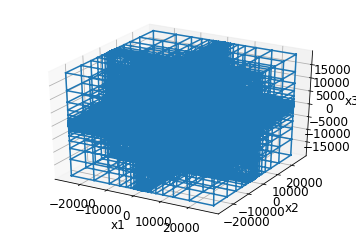

In [9]:
mesh.plotGrid()

In [10]:
print(f"There are {mesh.nC} cells in the mesh")

There are 39304 cells in the mesh


### put the model on the mesh

In [11]:
rho_h = rho_h_layers[0] * np.ones(mesh.nC) #Set bkgd to air 
rho_v = rho_v_layers[0] * np.ones(mesh.nC) 


for i, l in enumerate(layer_tops):
    z_inds = (mesh.gridCC[:, 2] <= l) #pulls all z indices below l
    rho_h[z_inds] = rho_h_layers[i + 1]  #sets each layer conductivity below each interface
    rho_v[z_inds] = rho_v_layers[i + 1]

rho_aniso = np.vstack([rho_h, rho_h, rho_v]).T  #x,y,z anisotropy. In this case x=y

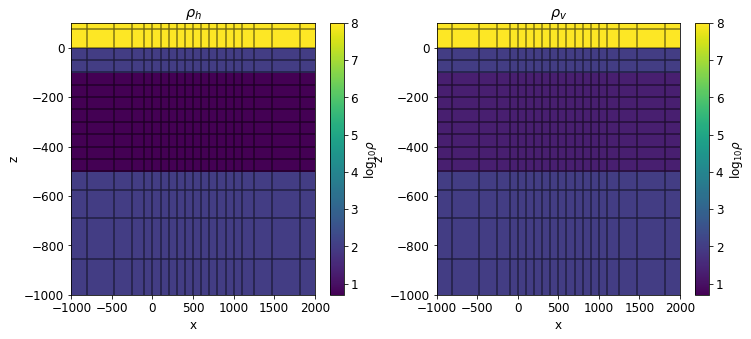

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
xlim = np.r_[-1000, 2000]
zlim = np.r_[-1000, 100]


for a, model, title in zip(ax, [rho_h, rho_v], ["$\\rho_h$", "$\\rho_v$"]): 
    
    plt.colorbar(
        mesh.plotSlice(np.log10(model), normal='y', ax=a, grid=True, clim=[np.log10(5), 8])[0], 
        ax=a, label="$\log_{10}\\rho$"
    )
    
    a.set_xlim(xlim)
    a.set_ylim(zlim)
    a.set_title(title)

## Set up the survey

In [13]:
rx_real = FDEM.Rx.Point_e(locs=rx_loc, orientation="x",component='real') #designate RX point
rx_imag = FDEM.Rx.Point_e(locs=rx_loc, orientation="x",component='imag')
#can do this for point, how to do it for long wire?
src = FDEM.Src.MagDipole(
        rxList=[rx_real, rx_imag], loc=src_a, orientation='x',  
        freq=freq
         )  # default waveform is a step-off

In [14]:
#prob_times = [(1e-6, 30), (1e-5, 20), (3e-5, 20), (1e-4, 30), (1e-3, 30), (1e-2, 30), (3e-2, 30)]

In [15]:
# isotropic problem 
survey_iso = FDEM.Survey([src])
prob_iso = FDEM.Problem3D_e(
    mesh, rhoMap=Maps.IdentityMap(mesh), Solver=Pardiso, 
    verbose=True
)
prob_iso.pair(survey_iso)

In [16]:
# anisotropic problem 
survey_aniso = FDEM.Survey([src])
prob_aniso = FDEM.Problem3D_e(
    mesh, rhoMap=Maps.IdentityMap(mesh), Solver=Pardiso, 
    verbose=True
)
prob_aniso.pair(survey_aniso)

## Compute the fields

In [17]:
%%time
fields_iso = prob_iso.fields(rho_h)

CPU times: user 49 s, sys: 1.21 s, total: 50.2 s
Wall time: 27.6 s


In [18]:
%%time
fields_aniso = prob_aniso.fields(rho_aniso)

CPU times: user 49.5 s, sys: 1.03 s, total: 50.6 s
Wall time: 27.6 s


## Compute the data

In [19]:
dpred_iso = survey_iso.dpred(rho_h, f=fields_iso)

In [20]:
dpred_aniso = survey_aniso.dpred(rho_aniso, f=fields_aniso)

## Plot the fields

In [21]:
def plot_currents(model, time_ind, loc_ind, xmin, xmax, ymin, ymax, normal="X", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        
    if model == "iso":
        currents = fields_iso[:, "j", time_ind]
    elif model == "aniso":
        currents = fields_aniso[:, "j", time_ind]
    
    
    plt.colorbar(mesh.plotSlice(
        currents, view="vec", vType="E", normal=normal, ind=loc_ind, 
        range_x=[xmin, xmax], range_y=[ymin, ymax], ax=ax, 
    )[0])
    
    ax.set_aspect(1)

In [22]:


data_iso_real = dpred_iso[0::2]
data_iso_imag = dpred_iso[1::2]

data_aniso_real = dpred_aniso[0::2]
data_aniso_imag = dpred_aniso[1::2]
print(np.shape(data_iso_real))
print(np.shape(dpred_aniso))

(200,)
(400,)


In [23]:
"""widgets.interact(
    plot_currents, 
    model=widgets.ToggleButtons(options=["iso", "aniso"]),
    freq_ind=widgets.IntSlider(min=0, max=prob_iso.Hz, value=0), 
    loc_ind=widgets.IntSlider(min=0, max=mesh.vnC.max(), value=npadx),
    xmin=widgets.FloatText(value=-1000.), 
    xmax=widgets.FloatText(value=2000.),
    ymin=widgets.FloatText(value=-1000.), 
    ymax=widgets.FloatText(value=0.),
    normal=widgets.ToggleButtons(options=["X", "Y", "Z"]),
    ax=widgets.fixed(None)
)"""

'widgets.interact(\n    plot_currents, \n    model=widgets.ToggleButtons(options=["iso", "aniso"]),\n    freq_ind=widgets.IntSlider(min=0, max=prob_iso.Hz, value=0), \n    loc_ind=widgets.IntSlider(min=0, max=mesh.vnC.max(), value=npadx),\n    xmin=widgets.FloatText(value=-1000.), \n    xmax=widgets.FloatText(value=2000.),\n    ymin=widgets.FloatText(value=-1000.), \n    ymax=widgets.FloatText(value=0.),\n    normal=widgets.ToggleButtons(options=["X", "Y", "Z"]),\n    ax=widgets.fixed(None)\n)'

## Plot the data

In [24]:
def plot_data(offset,data, ax, plot_type="semilogy", color="C0", label=None):
    #rcParams.update({'text.color': 'white'})
    getattr(ax, plot_type)(offset, data, color,linewidth=4, label=label) #This part confuses me
    
    if plot_type in ["semilogy", "loglog"]:
        getattr(ax, plot_type)(offset, -data, color+"--",linewidth=4)

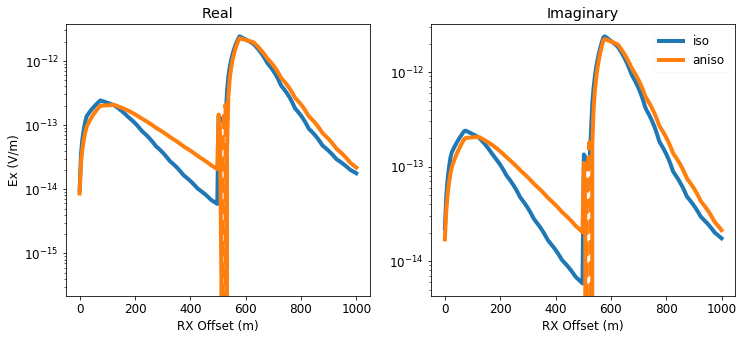

In [25]:
#rcParams.update({'text.color': 'white'})
offset=coil_separations
#with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white'}):

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_data(offset,data_iso_real, ax=ax[0], plot_type="semilogy", color="C0", label="iso")
plot_data(offset,data_aniso_real, ax=ax[0], plot_type="semilogy", color="C1", label="aniso")

plot_data(offset,data_iso_imag, ax=ax[1], plot_type="semilogy", color="C0", label="iso")
plot_data(offset,data_aniso_imag, ax=ax[1], plot_type="semilogy", color="C1", label="aniso")
ax[0].set_title('Real')
ax[0].set_xlabel('RX Offset (m)')
ax[0].set_ylabel('Ex (V/m)')

ax[1].set_title('Imaginary')
ax[1].set_xlabel('RX Offset (m)')
ax[1].legend(fancybox=True, framealpha=0.1)
#plt.savefig('SimPEG_FDEM.png', transparent=True)
"""
ax[0].semilogy(offset,np.abs(data_iso_real),linewidth=4)
ax[0].semilogy(offset,np.abs(data_aniso_real),'--',linewidth=4)
ax[0].set_title('Real')
ax[0].set_xlabel('RX Offset (m)')
ax[0].set_ylabel('Ex (V/m)')
ax[1].semilogy(offset,np.abs(data_iso_imag),linewidth=4)
ax[1].semilogy(offset[data_iso_imag>0],data_iso_imag[data_iso_imag>0],linewidth=4,color='c')
ax[1].semilogy(offset[data_iso_imag<=0],-data_iso_imag[data_iso_imag<=0],'--',linewidth=4,color='c')

plot_aniso_imag=data_aniso_imag
plot_aniso_imag
ax[1].semilogy(offset[data_aniso_imag>0],data_aniso_imag[data_aniso_imag>0],linewidth=4,color='m')
ax[1].semilogy(offset[data_aniso_imag<=0],-data_aniso_imag[data_aniso_imag<=0],'--',linewidth=4,color='m')
ax[1].set_title('Imaginary')
ax[1].set_xlabel('RX Offset (m)')

plt.tight_layout()
plt.figure()

plt.loglog(offset,np.abs(data_iso_real))
plt.loglog(offset,np.abs(data_aniso_real),'--')"""
#plt.plot(data_iso_imag)
#plt.plot(data_aniso_imag)
plt.show()


## Compare with empymod

In [26]:
"""
inp6 = {'src': [0, 0, 0, 400, 0.01, 0.01], #source at origin, .01 m z
        'rec': [1000, 0, 0.01, 0, 0], #source at x=1000, .01m z
        'depth': -layer_tops,
        'freqtime': rx_times, 
        'signal': -1, #Switch off
        'verb': 0} #How much info output

# Isotropic case
empymod_iso = bipole(res=rho_h_layers, aniso=[1, 1, 1, 1], **inp6)

# Keep horizontal resistivity constant
aniso_lay=[np.sqrt(rho_v_layers[ii]/rho_h_layers[ii]) for ii in range(0,len(rho_h_layers))] #Calculate aniso
empymod_aniso = bipole(res=rho_h_layers, aniso=aniso_lay, **inp6)"""

"\ninp6 = {'src': [0, 0, 0, 400, 0.01, 0.01], #source at origin, .01 m z\n        'rec': [1000, 0, 0.01, 0, 0], #source at x=1000, .01m z\n        'depth': -layer_tops,\n        'freqtime': rx_times, \n        'signal': -1, #Switch off\n        'verb': 0} #How much info output\n\n# Isotropic case\nempymod_iso = bipole(res=rho_h_layers, aniso=[1, 1, 1, 1], **inp6)\n\n# Keep horizontal resistivity constant\naniso_lay=[np.sqrt(rho_v_layers[ii]/rho_h_layers[ii]) for ii in range(0,len(rho_h_layers))] #Calculate aniso\nempymod_aniso = bipole(res=rho_h_layers, aniso=aniso_lay, **inp6)"

In [27]:
"""wire_length = 400

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_data(dpred_iso, ax=ax[0], plot_type="semilogy", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[0], plot_type="semilogy", color="C1", label="aniso")

plot_data(empymod_iso*wire_length, ax=ax[0], plot_type="semilogy", color="C2", label="empymod iso")
plot_data(empymod_aniso*wire_length, ax=ax[0], plot_type="semilogy", color="C3", label="empymod aniso")

plot_data(dpred_iso, ax=ax[1], plot_type="loglog", color="C0", label="iso")
plot_data(dpred_aniso, ax=ax[1], plot_type="loglog", color="C1", label="aniso")

plot_data(empymod_iso*wire_length, ax=ax[1], plot_type="loglog", color="C2", label="empymod iso")
plot_data(empymod_aniso*wire_length, ax=ax[1], plot_type="loglog", color="C3", label="empymod aniso")

ax[1].legend()

plt.tight_layout()"""

'wire_length = 400\n\nfig, ax = plt.subplots(1, 2, figsize=(12, 5))\n\nplot_data(dpred_iso, ax=ax[0], plot_type="semilogy", color="C0", label="iso")\nplot_data(dpred_aniso, ax=ax[0], plot_type="semilogy", color="C1", label="aniso")\n\nplot_data(empymod_iso*wire_length, ax=ax[0], plot_type="semilogy", color="C2", label="empymod iso")\nplot_data(empymod_aniso*wire_length, ax=ax[0], plot_type="semilogy", color="C3", label="empymod aniso")\n\nplot_data(dpred_iso, ax=ax[1], plot_type="loglog", color="C0", label="iso")\nplot_data(dpred_aniso, ax=ax[1], plot_type="loglog", color="C1", label="aniso")\n\nplot_data(empymod_iso*wire_length, ax=ax[1], plot_type="loglog", color="C2", label="empymod iso")\nplot_data(empymod_aniso*wire_length, ax=ax[1], plot_type="loglog", color="C3", label="empymod aniso")\n\nax[1].legend()\n\nplt.tight_layout()'